In [1]:
%matplotlib inline
%load_ext lab_black

import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_collection import load_time_series

resources = "resources/"
archive_path = os.path.join(resources, "dd_datakit.tar.gz")
data_path = os.path.join(resources, "data.csv.gz")
selected_data_path = os.path.join(resources, "full_time_series.csv.gz")

# Data collection

## Data download

The data we will be working with is [FluxDataKit v3.1](https://geco-bern.github.io/FluxDataKit/index.html), which is a compilation of ecosystem flux data aggregated from multiple [sources](https://geco-bern.github.io/FluxDataKit/index.html#data-sources).

The data and metadata can be downloaded from [Zenodo](https://zenodo.org/records/11370417):
- `FLUXDATAKIT_FLUXNET.tar.gz`: Archive containing CSV formatted time series.
- `fdk_site_info.csv`: Site metadata

The archive contains one hourly and one downsampled daily time series CSV file for each site.
Since we are only concerned about daily time series, we extract only these files (346 in total) and re-archive them using the following commands:

```bash
mkdir dd_datakit
tar -zxvf FLUXDATAKIT_FLUXNET.tar.gz -C dd_datakit --wildcards *FULLSET_DD*.csv
cd dd_datakit
tar -czvf ../dd_datakit.tar.gz *
```

Even compressed, this represents a large amount of data (> 100MB) which prevents us from uploading it to Github.
As will be discussed below, our study will focus on Deciduous Needleleaf Forests (DNF) and a few other sites for the cross-vegetation type generalization analysis.
For convenience purposes, all the necessary data is included in the `resource` directory.

## Data selection

We select the data we will be working with.

### Land cover type selection

Let us load the metadata file `fdk_site_info.csv`:

In [2]:
# Loading the sites info
site_df = pd.read_csv(
    os.path.join(resources, "fdk_site_info.csv"), index_col="sitename"
)
print(f"Number of sites: {len(site_df)}")
site_df.head()

Number of sites: 339


,lon,lat,elv,year_start,year_end,koeppen_code,igbp_land_use,whc,product
sitename,,,,,,,,,
AR-SLu,-66.459801,-33.464802,500.0,2010,2010,Bsk,MF,172.034241,plumber
AR-TF1,-66.733500,-54.973300,40.0,2016,2018,ET,WET,159.902341,ameriflux
AT-Neu,11.317500,47.116669,970.0,2002,2012,Dfc,GRA,239.951340,plumber
AU-ASM,133.248993,-22.283001,606.0,2011,2017,BSh,ENF,149.109436,plumber
AU-Cow,145.427155,-16.238190,86.0,2010,2015,Am,EBF,822.795186,plumber


There are 339 sites listed. Here is the description of the features present:

| Variable           | Description                                                               |
|--------------------|---------------------------------------------------------------------------|
| sitename           | Site name                                                                 |
| lon                | Longitude                                                                 |
| lat                | Latitude                                                                  |
| elv                | Elevation                                                                 |
| year_start         | Year start                                                                |
| year_end           | Year end (incl.)                                                          |
| koeppen_code       | Koeppen-Geiger code                                                       |
| igbp_land_use      | IGBP class                                                                |
| whc                | Water holding capacity                                                    |
| product            | Dataset where the data originates from                                    |

Let us display the location of the sites:

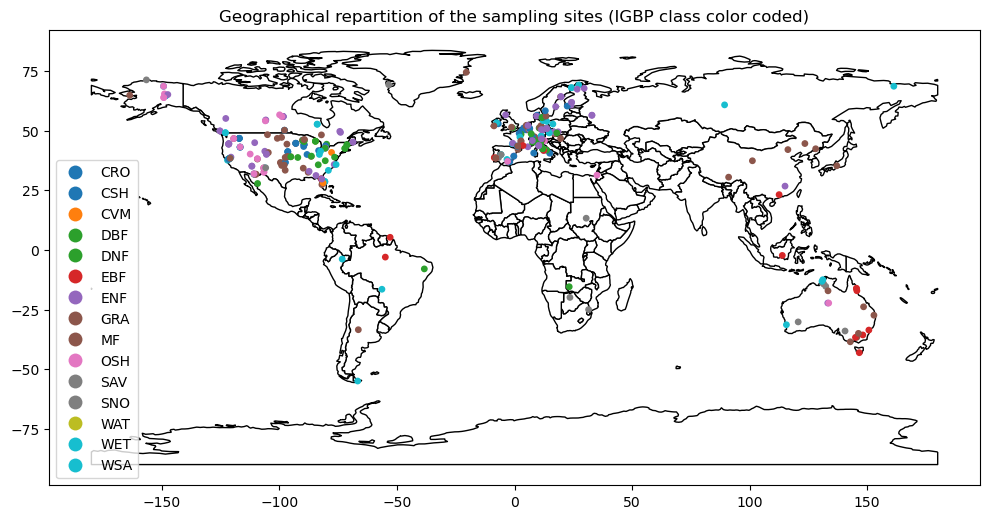

In [3]:
# Convert into a GeoDataFrame
sites_gdf = gpd.GeoDataFrame(
    site_df,
    geometry=gpd.points_from_xy(site_df["lon"], site_df["lat"]),
    crs="EPSG:4326",
)

# Wold map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Plot the data points on the map
fig, ax = plt.subplots(nrows=1, figsize=(10, 8))
world.plot(color="white", edgecolor="black", ax=ax)
sites_gdf.plot("igbp_land_use", s=15, legend=True, ax=ax)
ax.set_title("Geographical repartition of the sampling sites (IGBP class color coded)")
plt.tight_layout()
plt.show()

We wish to train our model on one land cover type. Let us find the one that is the most represented in our data:

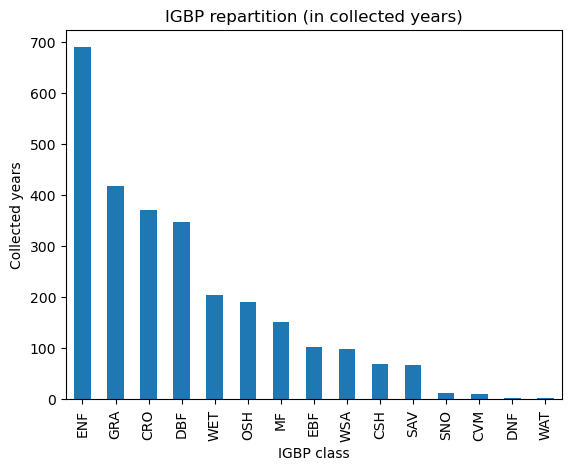

,count,mean,std,min,25%,50%,75%,max
igbp_land_use,,,,,,,,
ENF,70.0,9.842857,6.768717,1.0,5.00,7.0,13.00,25.0
GRA,63.0,6.634921,5.392054,1.0,3.00,5.0,7.00,24.0
CRO,47.0,7.872340,6.159535,1.0,3.00,5.0,11.00,23.0
DBF,35.0,9.942857,8.436416,1.0,5.00,6.0,15.50,33.0
WET,32.0,6.406250,4.606163,1.0,2.00,5.0,10.50,16.0
OSH,22.0,8.681818,5.592396,1.0,5.00,6.0,12.50,21.0
MF,17.0,8.882353,7.959918,1.0,3.00,6.0,12.00,25.0
EBF,16.0,6.375000,5.239275,1.0,2.75,5.0,8.00,17.0
WSA,13.0,7.615385,4.925080,1.0,5.00,7.0,11.00,16.0


In [4]:
# We add the duration (in years) covered by the sample
site_df["duration"] = site_df["year_end"] - site_df["year_start"] + 1
# We group by land cover type
site_gr = site_df.groupby("igbp_land_use")

# We sum the duration for each land cover type and plot the result
site_gr["duration"].sum().sort_values(ascending=False).plot.bar()
plt.title("IGBP repartition (in collected years)")
plt.xlabel("IGBP class")
plt.ylabel("Collected years")
plt.show()

# We print the statistics per land cover type
site_gr["duration"].describe().sort_values("count", ascending=False)

The cover type that is the most represented in the data is `ENF` (Evergreen Needleleaf Forest), with 70 sites and almost 700 years of combined daily samples.
The mean time series duration is almost 10 years and the longest series is 25 years.
This seems to be a good candidate for our study.
Others land cover sites are well represented as well and will be used for testing cross-land cover generalization.

### Data filtering and persistence

We load the files matching our criteria and build a dataframe:

For a later stage in our study, we will need a few well-formed time series which we will use for evaluating our models.
We choose the sites `CZ-RAJ` (ENF), `CZ-Stn` (DBF) and `CH-Cha` (GRA), which we save in separate files.
The rest of the ENF data is saved in `data.csv.gz`.

In [20]:
# Land cover class we focus this study on
main_igbp_class = "ENF"
# Select site (full time series analysis)
selected_site = "CZ-RAJ"
additional_sites = {"GRA": "CH-Cha", "DBF": "CZ-Stn"}  # Alt: AT-Neu  # Alt: DE-Hai

if os.path.exists(archive_path):
    # Load the data
    df = load_time_series(archive_path, site_df, [main_igbp_class])
    # Extract selected site
    selected_df = df[df["sitename"] == selected_site]
    selected_df.to_csv(selected_data_path, index=False)
    # Extract main class
    df_main = df[df["sitename"] != selected_site]
    df_main.to_csv(data_path, index=False)
    # Extract additional classes
    for igbp_class, site in additional_sites.items():
        df = load_time_series(archive_path, site_df, [igbp_class])
        selected_df = df[df["sitename"] == site]
        selected_df.to_csv(os.path.join(resources, f"{igbp_class}.csv.gz"), index=False)
else:
    print(f"Data file not found ({data_path}). Skipping.")

Discarding AU-ASM because all GPP values are missing.
Discarding CA-Qcu because all GPP values are missing.
Discarding DE-Bay because all GPP values are missing.
Discarding DE-Wet because all GPP values are missing.
Discarding DK-Gds because all GPP values are missing.
Discarding ES-ES1 because all GPP values are missing.
Discarding UK-Gri because all GPP values are missing.
Discarding US-Ho1 because all GPP values are missing.
Discarding US-Me4 because all GPP values are missing.
Discarding US-SP1 because all GPP values are missing.
Discarding US-SP2 because all GPP values are missing.

Loaded 59 sites (224641 samples).
Discarding AU-DaP because all GPP values are missing.
Discarding AU-Emr because all GPP values are missing.
Discarding AU-Otw because all GPP values are missing.
Discarding AU-Rig because all GPP values are missing.
Discarding AU-Sam because all GPP values are missing.
Discarding AU-Stp because all GPP values are missing.
Discarding AU-Ync because all GPP values are mi